In [ ]:
<h1 align="center">First Stage</h1>

# Goal

Predict the total stage duration based on the task durations of a reduced experiment with less VMs and input data.


# Strong-Scaling Experiment

Find below some information about the experiment whose logs are analysed in this work.

In [1]:
# Notebook configuration and modules import

# Show graph in this notebook instead of opening a window
%matplotlib inline
import matplotlib
# Make graphs more readable
matplotlib.rcParams.update({'font.size': 16,
                            'font.family': 'serif',
                            'lines.linewidth': 2})

from common import *

In [2]:
full_xp = Experiment('strong_scaling_data/app-*')  # Strong-scaling experiment

In [3]:
# Some experiment information

TOTAL_DATA = 48542876756
BLOCK_SIZE = 128 * 1024 * 1024
THREADS = 2

full_hdfs = HDFS(data_size=TOTAL_DATA, block_size=BLOCK_SIZE)

# Number of tasks in each application (first stage)
ns_tasks = set([len(app.stages[0].tasks) for app in full_xp.get_apps()])
assert len(ns_tasks) == 1  # All executions have the same number of tasks
n_tasks = ns_tasks.pop()
assert n_tasks == full_hdfs.n_blocks  # 1 task per hdfs block

info = '* Input size: {:.1f} GB\n'.format(full_hdfs.data_size/1024**3)
info += '* Input blocks (128 MB each) == number of tasks: {:d}\n'.format(full_hdfs.n_blocks)
info += '* Worker amounts: {}\n'.format(', '.join((str(w) for w in full_xp.n_nodes)))
info += '* Executions: {:d} (30 for each worker amount)\n'.format(full_xp.n_apps)
info += '* Total number of tasks: {:d} x {:d} = {:d}'.format(full_xp.n_apps, n_tasks, full_xp.n_apps * n_tasks)
Markdown(info)

* Input size: 45.2 GB
* Input blocks (128 MB each) == number of tasks: 362
* Worker amounts: 4, 8, 16, 32, 64
* Executions: 150 (30 for each worker amount)
* Total number of tasks: 150 x 362 = 54300

## Stage durations
The figure below shows the stage durations from all the executions. The line that connects their means will be used in other figures to compare with the model results.

In [4]:
full_xp.reject_stage_outliers(stage=0, std_m=5)

INFO: Removed outlier (8, 228290).


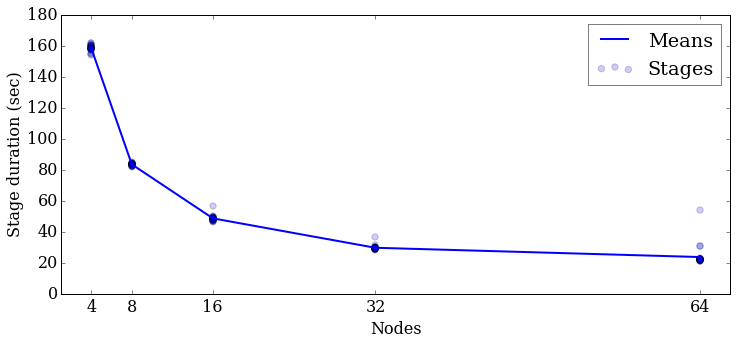

All stage durations and their means per number of nodes.

In [5]:
def plot_stage_durations(xp):
    pltr = Plotter('Stage duration (sec)', scale=0.001)
    xs = xp.get_stage_n_nodes()
    ys = xp.get_stage_durations(stage=0)
    pltr.scatter(xs, ys, label='Stages')

    xs = xp.n_nodes
    ys = xp.get_stage_duration_lists(stage=0)
    pltr.plot_means(xs, ys)

    pltr.end()
    
plot_stage_durations(full_xp)
Markdown('All stage durations and their means per number of nodes.')

## Task model

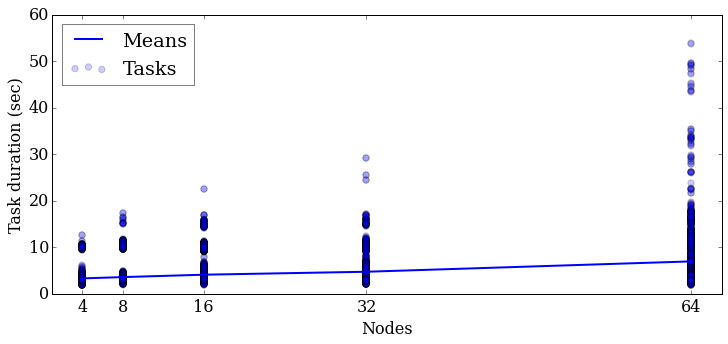

In [6]:
def plot_task_durations(xp, *args, **kwargs):
    pltr = Plotter('Task duration (sec)', scale=0.001)
    xs = xp.get_task_n_nodes(stage=0)
    ys = xp.get_task_durations(stage=0)
    pltr.scatter(xs, ys, label='Tasks')

    xs = xp.n_nodes
    ys = xp.get_task_duration_lists(stage=0)
    pltr.plot_means(xs, ys)

    pltr.end(*args, **kwargs)
    
plot_task_durations(full_xp, loc='upper left')

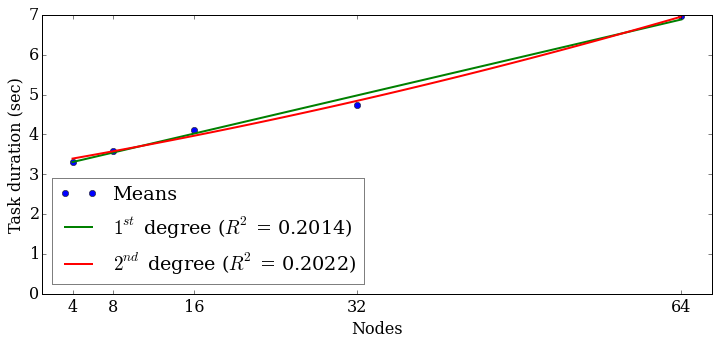

In [7]:
pltr = Plotter('Task duration (sec)', scale=0.001)

xs = full_xp.n_nodes
ys = full_xp.get_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'o')

xs = list(full_xp.get_task_n_nodes(0))
ys = list(full_xp.get_task_durations(0))

poly1 = get_polynomial(xs, ys, 1)
r2 = get_r2_from_poly(xs, ys, poly1)
pltr.plot_polynomial(full_xp.n_nodes, poly1, 'g-', r2=r2, label='$1^{st}$ degree')

poly2 = get_polynomial(xs, ys, 2)
r2 = get_r2_from_poly(xs, ys, poly2)
pltr.plot_polynomial(full_xp.n_nodes, poly2, 'r-', r2=r2, label='$2^{nd}$ degree')

pltr.end()

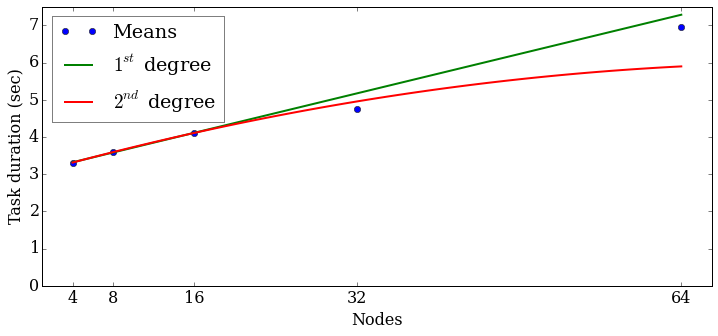

In [8]:
pltr = Plotter('Task duration (sec)', scale=0.001)

xs = full_xp.n_nodes
ys = full_xp.get_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'o')

xs = list(full_xp.get_task_n_nodes(stage=0, n_nodes=[4, 8, 16]))
ys = list(full_xp.get_task_durations(stage=0, n_nodes=[4, 8, 16]))

poly1 = get_polynomial(xs, ys, 1)
pltr.plot_polynomial(full_xp.n_nodes, poly1, 'g-', label='$1^{st}$ degree')

poly2 = get_polynomial(xs, ys, 2)
pltr.plot_polynomial(full_xp.n_nodes, poly2, 'r-', label='$2^{nd}$ degree')

pltr.end()

In [9]:
pp_xp = Experiment('small_strong_scaling_data2/app-*')
PP_DATA = 1073741798
pp_hdfs = HDFS(PP_DATA, BLOCK_SIZE)

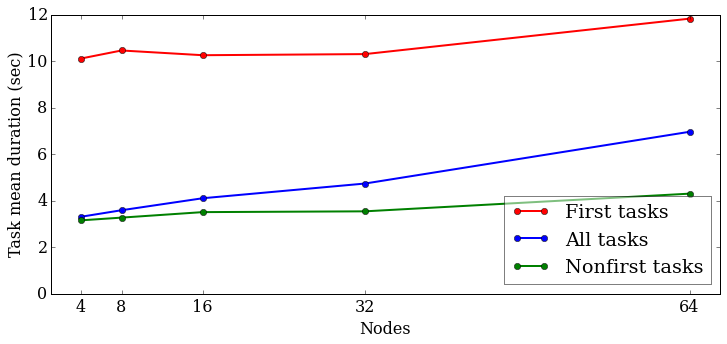

In [10]:
def plot_two_durations(xp, *args, **kwargs):
    pltr = Plotter('Task mean duration (sec)', scale=0.001)
    
    xs = xp.n_nodes
    ys = xp.get_first_task_duration_lists(stage=0)
    pltr.plot_means(xs, ys, 'r-o', label='First tasks')
    
    ys = xp.get_task_duration_lists(stage=0)
    pltr.plot_means(xs, ys, 'b-o', label='All tasks')
    
    ys = xp.get_nonfirst_task_duration_lists(stage=0)
    pltr.plot_means(xs, ys, 'g-o', label='Nonfirst tasks')
    
    pltr.end(*args, **kwargs)

plot_two_durations(full_xp, loc='lower right')

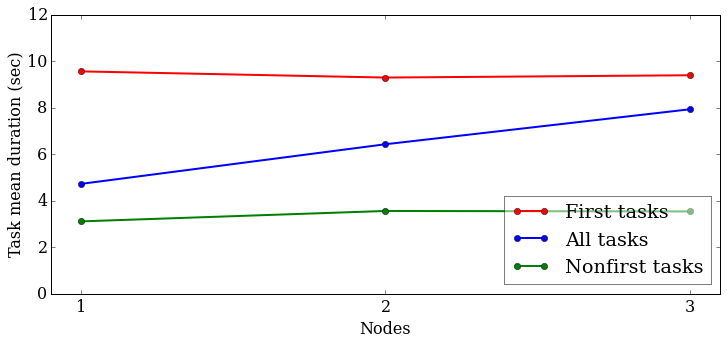

In [11]:
plot_two_durations(pp_xp, ymax=12, loc='lower right')

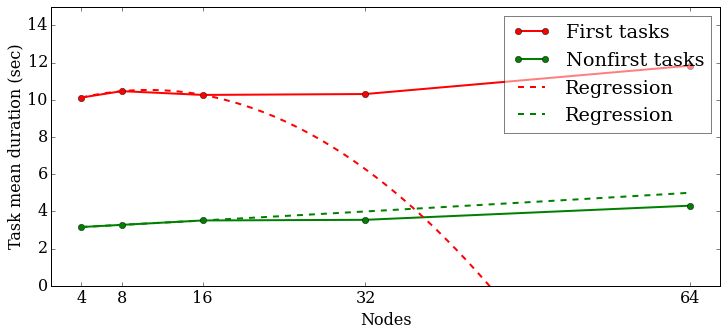

In [12]:
pltr = Plotter('Task mean duration (sec)', scale=0.001)

first3 = full_xp.n_nodes[:3]
xs = full_xp.n_nodes
ys = full_xp.get_first_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'r-o', label='First tasks')

ys = full_xp.get_nonfirst_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'g-o', label='Nonfirst tasks')

xs = full_xp.get_first_task_n_nodes(stage=0, n_nodes=first3)
ys = full_xp.get_first_task_durations(stage=0, n_nodes=first3)
poly_first = get_polynomial(xs, ys, 2)
pltr.plot_polynomial(full_xp.n_nodes, poly_first, 'r--')

xs = full_xp.get_nonfirst_task_n_nodes(stage=0, n_nodes=first3)
ys = full_xp.get_nonfirst_task_durations(stage=0, n_nodes=first3)
poly_nonfirst = get_polynomial(xs, ys, 2)
pltr.plot_polynomial(full_xp.n_nodes, poly_nonfirst, 'g--')

pltr.end()

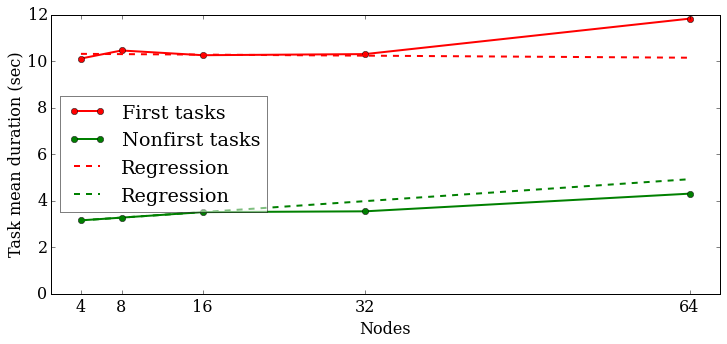

In [13]:
pltr = Plotter('Task mean duration (sec)', scale=0.001)

first3 = full_xp.n_nodes[:3]
xs = full_xp.n_nodes
ys = full_xp.get_first_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'r-o', label='First tasks')

ys = full_xp.get_nonfirst_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'g-o', label='Nonfirst tasks')

xs = full_xp.get_first_task_n_nodes(stage=0, n_nodes=first3)
ys = full_xp.get_first_task_durations(stage=0, n_nodes=first3)
poly_first = get_polynomial(xs, ys, 1)
pltr.plot_polynomial(full_xp.n_nodes, poly_first, 'r--')

xs = full_xp.get_nonfirst_task_n_nodes(stage=0, n_nodes=first3)
ys = full_xp.get_nonfirst_task_durations(stage=0, n_nodes=first3)
poly_nonfirst = get_polynomial(xs, ys, 1)
pltr.plot_polynomial(full_xp.n_nodes, poly_nonfirst, 'g--')

pltr.end()

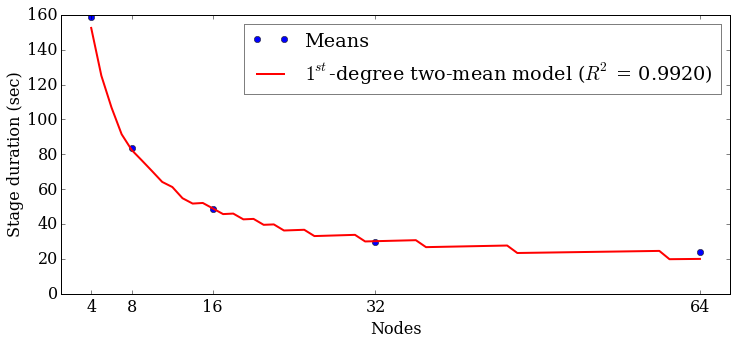

In [14]:
pltr = Plotter('Stage duration (sec)', scale=0.001)

xs = full_xp.n_nodes
ys = full_xp.get_stage_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'o')

models = TaskModels(TOTAL_DATA, BLOCK_SIZE, THREADS)
model = models.get_two_mean_model(poly_first, poly_nonfirst)
xs = full_xp.get_stage_n_nodes()
ys = full_xp.get_stage_durations(stage=0)
r2 = get_r2_from_model(xs, ys, model)
pltr.plot_model(full_xp.n_nodes, model, r2, 'r-', label='$1^{st}$-degree two-mean model')

pltr.end()

# Profiling Phase

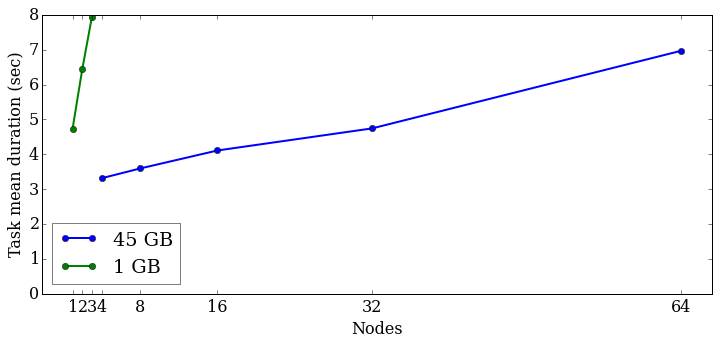

In [15]:
pltr = Plotter('Task mean duration (sec)', scale=0.001)

xs = full_xp.n_nodes
ys = full_xp.get_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, '-o', label='45 GB')

xs = pp_xp.n_nodes
ys = pp_xp.get_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, '-o', label='1 GB')

pltr.end()

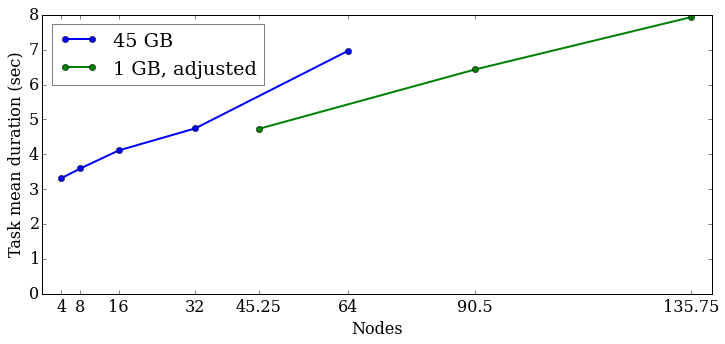

In [16]:
pltr = Plotter('Task mean duration (sec)', scale=0.001)

xs = full_xp.n_nodes
ys = full_xp.get_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, '-o', label='45 GB')

xs_adj = np.array(pp_xp.n_nodes) * full_hdfs.n_blocks / pp_hdfs.n_blocks
ys = pp_xp.get_task_duration_lists(stage=0)
pltr.plot_means(xs_adj, ys, '-o', label='1 GB, adjusted')

xticks = list(xs) + list(xs_adj)
pltr.set_xticks(list(xs) + list(xs_adj), ['{:g}'.format(x) for x in xticks])
pltr.end()

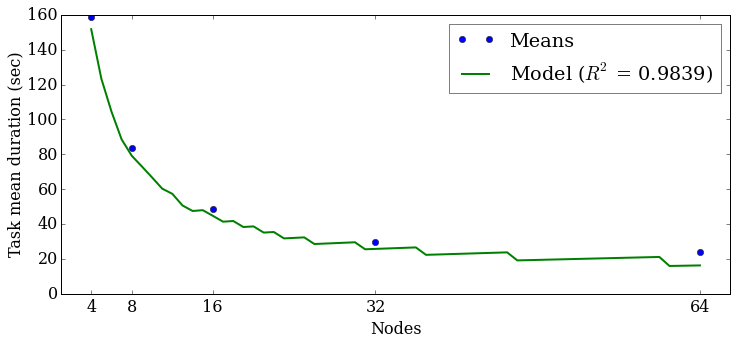

In [17]:
pltr = Plotter('Task mean duration (sec)', scale=0.001)

xs = full_xp.n_nodes
ys = full_xp.get_stage_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'o')

xs = pp_xp.get_task_n_nodes(stage=0)
adj_xs = np.array(list(xs)) * full_hdfs.n_blocks / pp_hdfs.n_blocks
ys = pp_xp.get_task_durations(stage=0)
poly = get_polynomial(adj_xs, ys, 1)
models = TaskModels(TOTAL_DATA, BLOCK_SIZE, THREADS)
model = models.get_poly_model(poly)
xs = full_xp.get_stage_n_nodes()
ys = full_xp.get_stage_durations(stage=0)
r2 = get_r2_from_model(xs, ys, model)
pltr.plot_model(full_xp.n_nodes, model, r2)

pltr.end()

In [153]:
print(poly_first)
print(poly_nonfirst)

xs = pp_xp.get_first_task_n_nodes(stage=0)
ys = pp_xp.get_first_task_durations(stage=0)
poly_first = get_polynomial(xs, ys, 1)

xs = pp_xp.get_nonfirst_task_n_nodes(stage=0)
ys = pp_xp.get_nonfirst_task_durations(stage=0)
poly_nonfirst = get_polynomial(xs, ys, 1)

print(poly_first)
print(poly_nonfirst)

[   99.82222222  9173.16111111]
[   99.82222222  3157.05      ]
[  -46.985  9504.14 ]
[  260.515  2900.8  ]


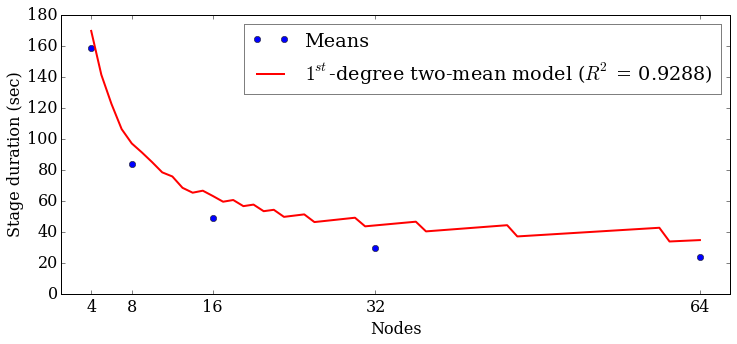

In [164]:
pltr = Plotter('Stage duration (sec)', scale=0.001)

xs = full_xp.n_nodes
ys = full_xp.get_stage_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'o')

models = TaskModels(TOTAL_DATA, BLOCK_SIZE, THREADS)
xs = full_xp.get_stage_n_nodes()
ys = full_xp.get_stage_durations(stage=0)

model = models.get_two_mean_model(poly_first, poly_nonfirst)
r2 = get_r2_from_model(xs, ys, model)
pltr.plot_model(full_xp.n_nodes, model, r2, 'r-', label='$1^{st}$-degree two-mean model')

pltr.end()

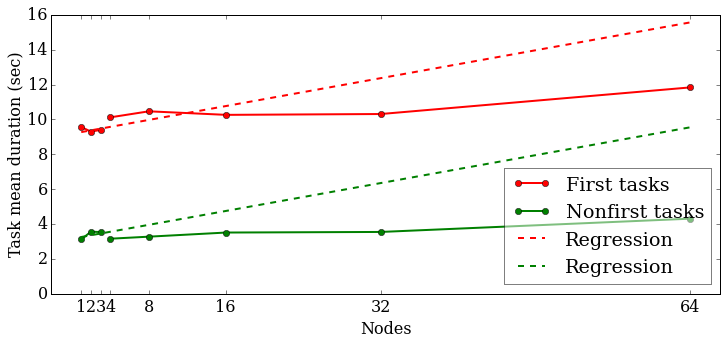

In [173]:
pltr = Plotter('Task mean duration (sec)', scale=0.001)

xs = pp_xp.n_nodes
ys = pp_xp.get_first_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'r-o', label='First tasks')

ys = pp_xp.get_nonfirst_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'g-o', label='Nonfirst tasks')

xs = full_xp.n_nodes
ys = full_xp.get_first_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'r-o', label=None)

ys = full_xp.get_nonfirst_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'g-o', label=None)

xs = pp_xp.n_nodes + full_xp.n_nodes
pltr.plot_polynomial(xs, poly_first, 'r--')
pltr.plot_polynomial(xs, poly_nonfirst, 'g--')

pltr.end()

# New - 2015-10-08

Trying to generate the red and green line based on the blue (mean) one. Smoother lines will lead to better regressions.

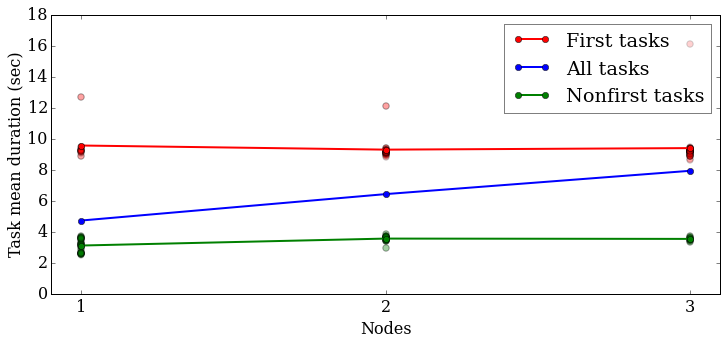

In [114]:
xp = pp_xp

pltr = Plotter('Task mean duration (sec)', scale=0.001)

xs = xp.n_nodes
ys = xp.get_first_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'r-o', label='First tasks')

ys = xp.get_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'b-o', label='All tasks')

ys = xp.get_nonfirst_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'g-o', label='Nonfirst tasks')

xs = xp.get_first_task_n_nodes(stage=0)
ys = xp.get_first_task_durations(stage=0)
pltr.scatter(xs, ys, c='r')

xs = xp.get_nonfirst_task_n_nodes(stage=0)
ys = xp.get_nonfirst_task_durations(stage=0)
pltr.scatter(xs, ys, c='g')

pltr.end()

## Relation between first and nonfirst tasks

Starting with (3114, 9490) = 76.06
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 70
Finished with (3141, 9486) = 0.00
Starting with (3562, 9355) = 54.20
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 36
         Function evaluations: 72
Finished with (3470, 9393) = 0.00
Starting with (3542, 9364) = 35.60
Optimization terminated successfully.
         Current function value: 28.220860
         Iterations: 37
         Function evaluations: 83
Finished with (3388, 9423) = 28.22


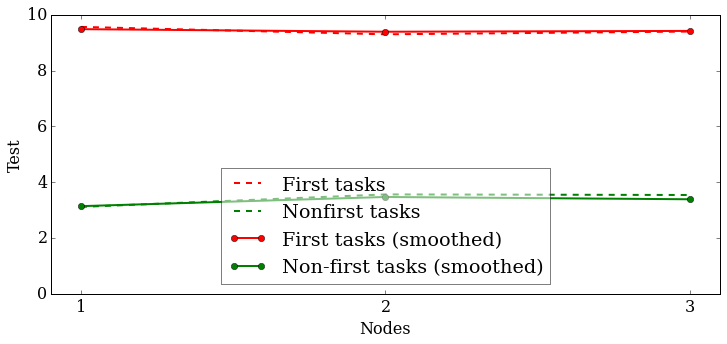

In [149]:
from scipy.optimize import minimize
from functools import partial

xs = np.array(list(pp_xp.get_nonfirst_task_durations(stage=0)))
ys = np.array(list(pp_xp.get_first_task_durations(0)))
non2first_1d = np.polyfit(xs, ys, 1)
non2first_2d = np.polyfit(xs, ys, 2)

def _smooth_ys(threads, n_tasks, non2first, t_mean, nodes, t_nonfirst_init):
    n_first = nodes * threads
    n_nonfirst = n_tasks - n_first
    ratio = n_nonfirst/n_first
    
    def get_t_first_from_ratio(t_nonfirst):
        return -ratio * t_nonfirst + (ratio + 1) * t_mean

    def minimizeme(t_nonfirst):
        t_first_1 = get_t_first_from_ratio(t_nonfirst)
        t_first_2 = np.polyval(non2first, t_nonfirst)
        return abs(t_first_1 - t_first_2)

    x0 = t_nonfirst_init
    print('Starting with ({:.0f}, {:.0f}) = {:.2f}'.format(x0, np.polyval(non2first, x0), minimizeme(x0)))
    res = minimize(minimizeme, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
    resx = res.x[0]
    print('Finished with ({:.0f}, {:.0f}) = {:.2f}'.format(resx, np.polyval(non2first, resx), minimizeme(resx)))
    
    return np.polyval(non2first, resx), resx

smooth_ys = partial(_smooth_ys, THREADS, pp_hdfs.n_blocks, non2first_2d)
smooth_first, smooth_nonfirst = [], []
initials = (np.mean(list(durs)) for durs in pp_xp.get_nonfirst_task_duration_lists(0))
means = (np.mean(list(durs)) for durs in pp_xp.get_task_duration_lists(0))
for nodes, t_mean, t_nonfirst_init in zip(pp_xp.n_nodes, means, initials):
    first, nonfirst = smooth_ys(t_mean, nodes, t_nonfirst_init)
    smooth_first.append(first)
    smooth_nonfirst.append(nonfirst)

smooth_first, smooth_nonfirst = np.array(smooth_first), np.array(smooth_nonfirst)
    
pltr = Plotter('Test', scale=0.001)

xs = xp.n_nodes
ys = xp.get_first_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'r--', label='First tasks')

ys = xp.get_nonfirst_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'g--', label='Nonfirst tasks')

plt.plot(pp_xp.n_nodes, smooth_first/1000, 'r-o', label='First tasks (smoothed)')
plt.plot(pp_xp.n_nodes, smooth_nonfirst/1000, 'g-o', label='Non-first tasks (smoothed)')
pltr.add_xticks(pp_xp.n_nodes)
pltr.end()

poly_first = np.polyfit(pp_xp.n_nodes, smooth_first, 1)
poly_nonfirst = np.polyfit(pp_xp.n_nodes, smooth_nonfirst, 1)

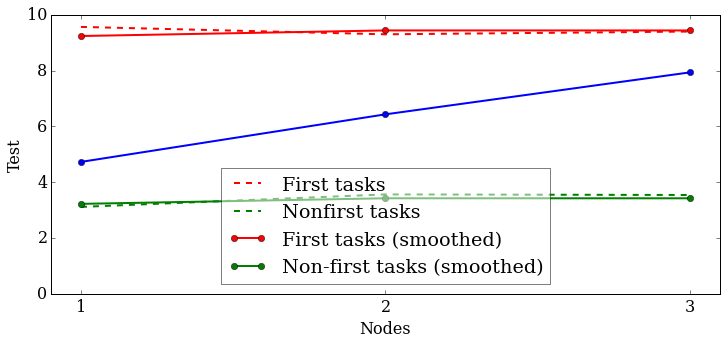

In [172]:
ratios = []
alls = []

def process_nn_apps(apps):
    workers = apps[0].slaves * THREADS
    all_nn = []
    for app in apps:
        tasks = app.stages[0].tasks
        a11 = np.mean([t.duration for t in tasks])
        nonfirst = np.mean([t.duration for t in tasks[workers:]])
        all_nn.append(a11)
        ratios.append((a11 - nonfirst)/workers)
    alls.append(np.mean(all_nn))

for nn in pp_xp.n_nodes:
    nn_apps = pp_xp.apps[nn]
    process_nn_apps(nn_apps)

ratios = np.array(ratios)
ratio = ratios.mean()

#ratio = ratio / full_hdfs.n_blocks * pp_hdfs.n_blocks
firsts, nonfirsts = [], []
for nn, a11 in zip(pp_xp.n_nodes, alls):
    n_first_tasks = nn * THREADS
    n_nonfirst_tasks = pp_hdfs.n_blocks - n_first_tasks
    first = a11 + ratio * n_nonfirst_tasks
    nonfirst = a11 - ratio * n_first_tasks
    firsts.append(first)
    nonfirsts.append(nonfirst)
    
firsts, nonfirsts = np.array(firsts), np.array(nonfirsts)
pltr = Plotter('Test', scale=0.001)

xs = pp_xp.n_nodes
ys = pp_xp.get_first_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'r--', label='First tasks')

ys = pp_xp.get_nonfirst_task_duration_lists(stage=0)
pltr.plot_means(xs, ys, 'g--', label='Nonfirst tasks')

plt.plot(pp_xp.n_nodes, firsts/1000, 'r-o', label='First tasks (smoothed)')
plt.plot(pp_xp.n_nodes, nonfirsts/1000, 'g-o', label='Non-first tasks (smoothed)')
plt.plot(pp_xp.n_nodes, np.array(alls)/1000, 'b-o')
pltr.add_xticks(pp_xp.n_nodes)
pltr.end()

poly_first = np.polyfit(pp_xp.n_nodes, firsts, 1)
poly_nonfirst = np.polyfit(pp_xp.n_nodes, nonfirsts, 1)